In [1]:
import itertools, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import colors

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *

import evcouplings.align, evcouplings.couplings

In [2]:
output = True
N = 9
q = naminoacids

proteome = proteome_path('Human')
seed = 1234
prng = np.random.RandomState(seed)

In [3]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [4]:
datasets = ['train', 'test', 'model']
sample_matrices = {}
for dataset in datasets:
    sample_matrices[dataset] =  np.loadtxt('data/%s_matrix.csv.gz' % dataset).astype(int)

In [5]:
for dataset in datasets:
    print(dataset, sample_matrices[dataset].shape)

train (5702936, 9)
test (5646474, 9)
model (5646474, 9)


In [51]:
fis = {}
fijs = {}
cijs = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fi = frequencies(matrix, num_symbols=q, pseudocount=0.0)
    fis[dataset] = fi
    fij = pair_frequencies(matrix, num_symbols=q, fi=fi, pseudocount=0.0)
    fijs[dataset] = fij
    cij = compute_covariance_matrix(fi=fi, fij=fij)
    cijs[dataset] = cij

In [9]:
fijks = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fijk = triplet_frequencies(matrix, num_symbols=q, pseudocount=0.0)
    fijks[dataset] = fijk

In [12]:
cijks = {}
for dataset in datasets:
    matrix = sample_matrices[dataset]
    fij = fijs[dataset]
    fi = fis[dataset]
    fijk = fijks[dataset]
    cijk = compute_cijk(fijk, fij, fi)
    cijks[dataset] = cijk

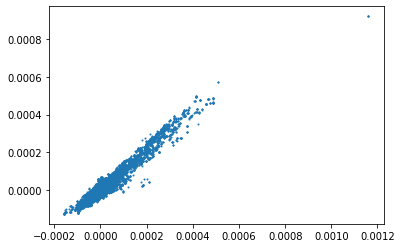

In [13]:
plt.plot(flatten_ijk(cijks['test']), flatten_ijk(cijks['train']), 'o', ms=1)

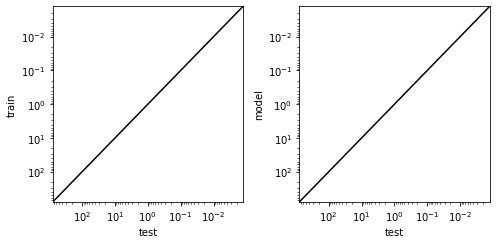

In [45]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
for i, dataset in enumerate(['train', 'model']):
    plotting.density_scatter(flatten_ijk(cijks['test']),
                             flatten_ijk(cijks[dataset]),
                             trans=lambda x: np.log(x+1e-3),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel(dataset)
for ax in axes:
    max_ = 1.1*flatten_ijk(cijks['test']).max()
    lims = 1/max_, max_
    ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('test')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
fig.tight_layout()

In [20]:
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=N)
independent_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi, np.zeros_like(Jij)), jump, 1e7, nsample=10)

In [21]:
fi_independent = frequencies(independent_matrix, num_symbols=q, pseudocount=0.0)
fij_independent = pair_frequencies(independent_matrix, num_symbols=q, fi=fi_independent, pseudocount=0.0)
fijk_independent = triplet_frequencies(independent_matrix, num_symbols=q, pseudocount=0.0)

In [22]:
cijk_independent = compute_cijk(fijk_independent, fij_independent, fi_independent)

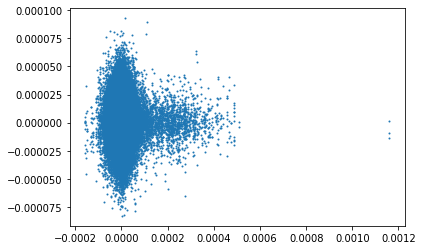

In [23]:
plt.plot(flatten_ijk(cijks['test']), flatten_ijk(cijk_independent), 'o', ms=1)

In [16]:
foldijks = {}
for dataset in datasets:
    fijk = fijks[dataset]
    fi = fis[dataset]
    fold_ijk = fijk / (fi[:, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis] *
                fi[np.newaxis, :, np.newaxis, np.newaxis, :, np.newaxis] *
                fi[np.newaxis, np.newaxis :, np.newaxis, np.newaxis, :])
    foldijks[dataset] = fold_ijk

In [3]:
params = np.load('data/Human_full_k9.npz')
hi = params['hi']
Jij = params['Jij']

In [9]:
list(zip(aminoacids, hi.std(axis=0)))

[('A', 0.0035406579075383795),
 ('C', 0.0014893643088148595),
 ('D', 0.0013892198615577393),
 ('E', 0.0009110189563667492),
 ('F', 0.0013412697278855862),
 ('G', 0.0014000822211791095),
 ('H', 0.002127311629294183),
 ('I', 0.0020652620217782598),
 ('K', 0.0026846894372483626),
 ('L', 0.0011654184849189324),
 ('M', 0.026951582205213515),
 ('N', 0.0012834177758636997),
 ('P', 0.0009682044299691245),
 ('Q', 0.0013840474784771529),
 ('R', 0.001142693073953028),
 ('S', 0.0009424551613649941),
 ('T', 0.0011721207550945312),
 ('V', 0.0008010794265122387),
 ('W', 0.0014400674267044922),
 ('Y', 0.0022629432493179095)]

In [4]:
observables = ['fi', 'fij', 'cij', 'fijk', 'cijk', 'fold_ijk']#, 'fijkl']
observables_dict = {key: dict() for key in observables}
for dataset in ['train', 'test', 'model']:
    params = np.load('data/%s_observables.npz'%dataset)
    for observable in observables:
        observables_dict[observable][dataset] = params[observable]

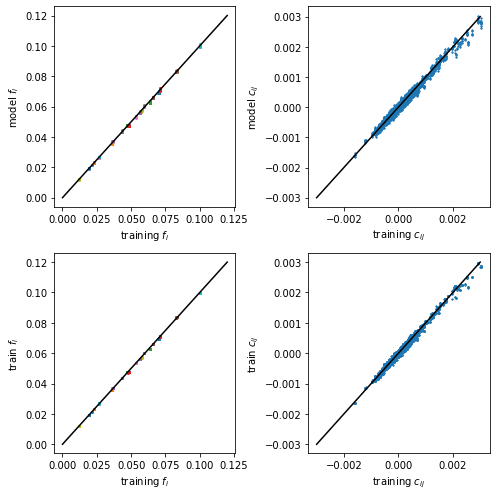

In [5]:
fig, axes = plt.subplots(figsize=(7, 7), ncols=2, nrows=2)

for i, dataset in enumerate(['model', 'train']):
    ax = axes[i, 0]
    fis = observables_dict['fi']
    ax.plot(fis['test'], fis[dataset], 'o', ms=2)
    ax.set_xlabel('training $f_i$')
    ax.set_ylabel('%s $f_i$'%dataset)
    ax.plot([0, 0.12], [0, 0.12], 'k')

lim = 0.003
for i, dataset in enumerate(['model', 'train']):
    ax = axes[i, 1]
    cijs = observables_dict['cij']
    cij = cijs['test']
    ax.plot(flatten_ij(cij), flatten_ij(cijs[dataset]), 'o', ms=1)
    ax.set_ylabel('%s $c_{ij}$'%dataset)
    ax.set_xlabel('training $c_{ij}$')
    ax.plot([-lim, lim], [-lim, lim], 'k')

fig.tight_layout()

/home/amayer/.conda/envs/py3/lib/python3.6/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


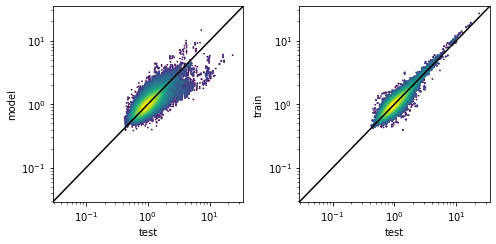

In [6]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
for i, dataset in enumerate(['model', 'train']):
    plotting.density_scatter(flatten_ijk(observables_dict['fold_ijk']['test']),
                             flatten_ijk(observables_dict['fold_ijk'][dataset]),
                             trans=lambda x: np.log(x),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel(dataset)
for ax in axes:
    max_ = 1.1*flatten_ijk(observables_dict['fold_ijk']['test']).max()
    lims = 1/max_, max_
    ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('test')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
fig.tight_layout()

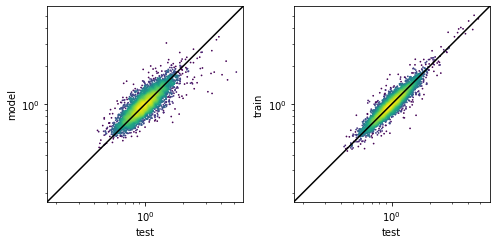

In [7]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
for i, dataset in enumerate(['model', 'train']):
    plotting.density_scatter(observables_dict['fold_ijk']['test'][3,4,5].flatten(),
                             observables_dict['fold_ijk'][dataset][3,4,5].flatten(),
                             trans=lambda x: np.log(x),
                             norm=colors.LogNorm(vmin=1),
                             s=0.5,
                             bins=50, ax=axes[i])
    axes[i].set_ylabel(dataset)
for ax in axes:
    max_ = 1.1*observables_dict['fold_ijk']['test'][3,4,5].flatten().max()
    lims = 1/max_, max_
    ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('test')
    ax.set_xlim(*lims)
    ax.set_ylim(*lims)
fig.tight_layout()

ind 0.0073301421024185645
model 0.001627483534581696
train 0.0004770915667735209


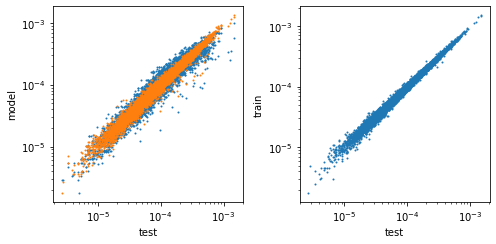

In [8]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)
for i, dataset in enumerate(['model', 'train']):
    if dataset == 'model':
        fi = observables_dict['fi']['train']
        fijk_ind = (fi[:, np.newaxis, np.newaxis, :, np.newaxis, np.newaxis] *
                 fi[np.newaxis, :, np.newaxis, np.newaxis, :, np.newaxis] *
                 fi[np.newaxis, np.newaxis :, np.newaxis, np.newaxis, :])
        test = observables_dict['fijk']['test'][3,4,5,:,:,:].flatten()
        data = fijk_ind[3,4,5,:,:,:].flatten()
        print('ind', calc_jsd(test, data))
        axes[i].plot(test, data, 'o', ms=1)
    test = observables_dict['fijk']['test'][3,4,5,:,:,:].flatten()
    data = observables_dict['fijk'][dataset][3,4,5,:,:,:].flatten()
    print(dataset, calc_jsd(test, data))
    axes[i].plot(test, data, 'o', ms=1)
    axes[i].set_ylabel(dataset)
for ax in axes:
    #max_ = 1.1*flatten_ijk(observables_dict['fijk']['test']).max()
    #lims = 1/max_, max_
    #ax.plot(lims, lims, 'k-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('test')
    #ax.set_xlim(*lims)
    #ax.set_ylim(*lims)
fig.tight_layout()

In [90]:
def compute_Jij_mf(cij_flat):
    invC = np.linalg.inv(cij_flat)
    Jij = 0.5*evcouplings.couplings.reshape_invC_to_4d(-invC, N, q)
    Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)
    return Jij_zerogauge

In [91]:
fi = observables_dict['fi']['train']
fij = observables_dict['fij']['train']
q = naminoacids
alpha = 0.01
fi_reg = (1-alpha)*observables_dict['fi']['train'] + alpha/q
fij_reg = (1-alpha)*observables_dict['fij']['train'] + alpha/q**2
cij_flat = compute_flattened_covariance_matrix(fi_reg, fij_reg)
Jij_mf = compute_Jij_mf(cij_flat)
hi_mf = evcouplings.couplings.fields(Jij_mf, fi)

In [81]:
invC4d = evcouplings.couplings.reshape_invC_to_4d(invC, N, q)
Jij_TAP = -2*invC4d/(1+(1-8*invC4d*fi[:, np.newaxis, :, np.newaxis]*fi[np.newaxis, :, np.newaxis, :])**.5)

/home/amayer/.conda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


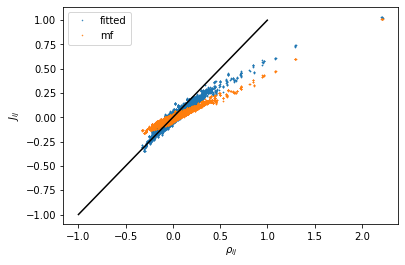

In [92]:
Jij_zerogauge = evcouplings.couplings.model._zero_sum_gauge(Jij)
k = N

rhoij = np.zeros(fij.shape)
for i in range(k):
    for j in range(k):
        rhoij[i, j] = fij[i, j]/np.outer(fi[i], fi[j]) - 1.0
mask = np.abs(Jij_zerogauge) > 1e-5
plt.plot(rhoij[mask].flatten(), Jij_zerogauge[mask].flatten(), '.', ms=1, label='fitted')
mask = np.abs(Jij_mf) > 1e-5
plt.plot(rhoij[mask].flatten(), Jij_mf[mask].flatten(), '.', ms=1, label='mf')
lim = 1.0
plt.plot([-lim, lim], [-lim, lim], 'k-')
plt.xlabel(r'$\rho_{ij}$')
plt.ylabel('$J_{ij}$')
plt.legend()

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        8.800e+01, 6.100e+02, 6.872e+03, 1.886e+04, 4.292e+03, 1.190e+03,
        3.220e+02, 1.060e+02, 2.600e+01, 1.200e+01, 1.000e+01, 0.000e+00,
        0.000e+00]),
 array([-1.        , -0.89473684, -0.78947368, -0.68421053, -0.57894737,
        -0.47368421, -0.36842105, -0.26315789, -0.15789474, -0.05263158,
         0.05263158,  0.15789474,  0.26315789,  0.36842105,  0.47368421,
         0.57894737,  0.68421053,  0.78947368,  0.89473684,  1.        ]),
 <a list of 1 Patch objects>)

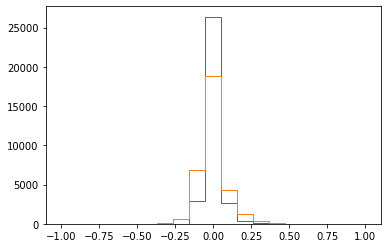

In [93]:
bins = np.linspace(-1, 1, 20)
plt.hist(Jij_mf.flatten(), bins=bins, histtype='step')
plt.hist(Jij_zerogauge.flatten(), bins=bins, histtype='step')

In [94]:
jump = lambda x: local_jump(x, q)
x0 = prng.randint(q, size=N)
sample_matrix = mcmcsampler(x0, lambda x: energy_potts(x, hi_mf, Jij_mf), jump, 1e6, nsample=10)

In [95]:
fi_mf = frequencies(sample_matrix, num_symbols=q)
fij_mf = pair_frequencies(sample_matrix, num_symbols=q, fi=fi_mf)
cij_mf = compute_covariance_matrix(fi_mf, fij_mf)

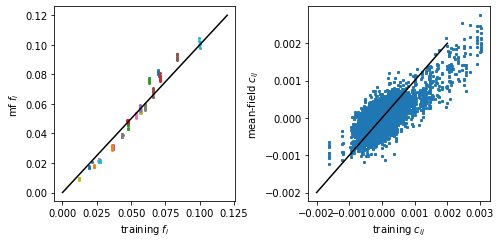

In [96]:
fig, axes = plt.subplots(figsize=(7, 3.5), ncols=2)

ax = axes[0]
ax.plot(fi, fi_mf, 'o', ms=2)
ax.set_xlabel('training $f_i$')
ax.set_ylabel('mf $f_i$')
ax.plot([0, 0.12], [0, 0.12], 'k')

lim = 0.002
ax = axes[1]
ax.plot(flatten_ij(cij), flatten_ij(cij_mf), 'o', ms=2)
ax.set_ylabel('mean-field $c_{ij}$')
ax.set_xlabel('training $c_{ij}$')
ax.plot([-lim, lim], [-lim, lim], 'k')

fig.tight_layout()